# Final Project: Self Driving Car 
---

## Setting the Enviroment.

 - Improting Libraries.

## Part 1: Dataset - Loading, Balancing and Preprocessing.

### Task: Load the 'Self_Driving_Car_Data' dataset and perform preprocessing procedures. 

#### Dataset Tasks:

 - Loading the Self_Driving_Car_Data.
 - Basic Datasets Visualization.
 - Extracting the Valid Features and Defining Label.
 - Splitting the Dataset into Training and Test Segments.
 - Preprocessing Images.
 - Data Augmentation.
 - Generator.
---

## Part 2: Behavioural Cloning.

### Task 1: Define Nvidia model and perform training procedures.

#### Building and Training Tasks:

 - Create Nvidia Model.
 - Compile the Model.
 - Create Model Callbacks.
 - Train the Model.
 - Save the Model.

### Task 2: Define comparison model - AlexNet (modified) and perform training procedures.

#### Building and Training Tasks:

 - Create AlexNet Model.
 - Compile the Model.
 - Create Model Callbacks.
 - Train the Model.
 - Save the Model.
 
### Task 3: Define transfer learning model - MobileNet and perform training procedures.
 
#### Building and Training Tasks:

 - Employe MobileNet Model.
 - Compile the Model.
 - Create Model Callbacks.
 - Train the Model.
 - Save the Model.
___

## Part 3: Analysis and Visualizing the Results.

### Task: Display the model predictions and perform analysis procedures.

#### Analyzing and Plotting Tasks:

 - Display Results.
 - Make Predictions.
 - Visualize the Predictions.
 - Metric Calculation.
 - Approximated Accuracy.
___

## Setting the Enviroment:

### Importing Libraries:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.applications import MobileNet
from matplotlib import rc
from keras.utils.vis_utils import plot_model

## Part 1: Dataset - Loading, Balancing and Preprocessing:

### Loading the Self_Driving_Car_Data:

In [3]:
# Dataset path:
datadir = 'Self_Driving_Car_Data'

# Column designation:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

# Reading the Self_Driving_Car_Data with the pd.read_csv method:
dataset = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)

In [4]:
# Split function 'path_tail':

def path_tail(path):
    
    """ Creating function for reducing path lenght and isolating the image name 
         Parameters
         ----------
         path : list
             path is list of strings to the dataset directories
         
         Returns
         -------
         tail : list
             list of strings with image names     
    """
    
    head, tail = ntpath.split(path)
    return tail

In [5]:
# Applying the 'path_tail' function:

# Selecting the tail element for the 'center', 'left' and 'right' columns:
dataset['center'] = dataset['center'].apply(path_tail)
dataset['left'] = dataset['left'].apply(path_tail)
dataset['right'] = dataset['right'].apply(path_tail)

# Printing the results:
dataset.head()

center                              left  \
0  center_2021_04_17_12_38_15_250.jpg  left_2021_04_17_12_38_15_250.jpg   
1  center_2021_04_17_12_38_15_318.jpg  left_2021_04_17_12_38_15_318.jpg   
2  center_2021_04_17_12_38_15_389.jpg  left_2021_04_17_12_38_15_389.jpg   
3  center_2021_04_17_12_38_15_459.jpg  left_2021_04_17_12_38_15_459.jpg   
4  center_2021_04_17_12_38_15_526.jpg  left_2021_04_17_12_38_15_526.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_04_17_12_38_15_250.jpg       0.0       0.0      0.0  0.000011  
1  right_2021_04_17_12_38_15_318.jpg       0.0       0.0      0.0  0.000008  
2  right_2021_04_17_12_38_15_389.jpg       0.0       0.0      0.0  0.000002  
3  right_2021_04_17_12_38_15_459.jpg       0.0       0.0      0.0  0.000018  
4  right_2021_04_17_12_38_15_526.jpg       0.0       0.0      0.0  0.000010

In [6]:
# Printing the lenght of the dataset:

# Dataset lenght:
lenght = {'Metric': ['Lenght'],
          'Features': [(len(dataset.columns))],
          'Instances': [(len(dataset))]          
         }

# Converting the data into DataFrame for clear reading:
table = pd.DataFrame(lenght)

# Printing the results:
table

Metric  Features  Instances
0  Lenght         7      20053

### Basic Datasets Visualization:

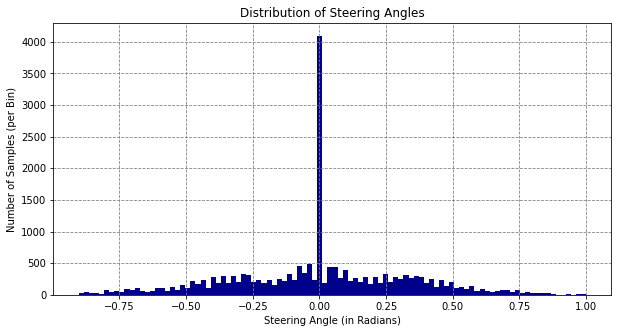

In [7]:
# Basic plotting of the dataset:
plt.figure(figsize = (10, 5))
plt.hist(dataset['steering'], bins = 100, color = 'darkblue')
plt.grid(color = 'grey', linestyle = '--')
plt.title('Distribution of Steering Angles')
plt.xlabel('Steering Angle (in Radians)')
plt.ylabel('Number of Samples (per Bin)')
plt.show()

### Extracting the Valid Features and Defining Label:

In [8]:
def load_image_steering(datadir, dataframe):
    
    """ Creating function that will extract the input features: center, left and right columns,
        and assigning steering column as label
         Parameters
         ----------
         datadir : list
             datadir contains the path to dataset images and driving_log.csv
         dataframe : Pandas DataFrame
             dataframe is the dataset from which we are extracting features and label
         
         Returns
         -------
         image_paths : array
             image_paths is one dimensional array with entries for center, left and right images
         steerings : float
             steerings is one dimensional array with measurments of steering angles
    """
    image_path = []
    steering = []
    for i in range(len(dataset)):
        indexed_data = dataset.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        # Center Image:
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # Left Image:
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        # Right Image:
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [9]:
# Calling the 'load_image_steering' function to unpack dataset for splitting:

image_paths, steerings = load_image_steering(datadir + '/IMG', dataset)

### Splitting the Dataset into Training and Test Segments:

 - Note : Splitting the dataset with ratio training = 0.8 and testing = 0.2.

In [10]:
# Dataset split X_train, X_test, y_train, y_test:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 1)

In [11]:
# Printing the results from dataset split:
result = {'Metric': ['Lenght'],
          'X_train': [(len(X_train))],
          'X_test': [(len(X_test))],
          'y_train' : [len(y_train)],
          'y_test' : [len(y_test)]          
          }

# Converting the data into DataFrame for clear reading:
table_ = pd.DataFrame(result)

# Printing the results:
table_

Metric  X_train  X_test  y_train  y_test
0  Lenght    48127   12032    48127   12032

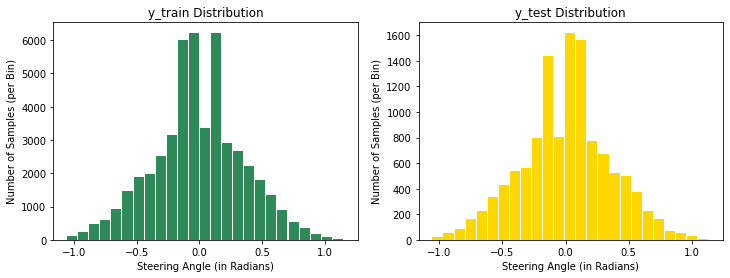

In [12]:
# Visualzing y-segments distibutions:

fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = 25, width = 0.08, color = 'seagreen')
axes[0].set_title('y_train Distribution')
axes[0].set_xlabel('Steering Angle (in Radians)')
axes[0].set_ylabel('Number of Samples (per Bin)')
axes[1].hist(y_test, bins = 25, width = 0.08, color = 'gold')
axes[1].set_title('y_test Distribution')
axes[1].set_xlabel('Steering Angle (in Radians)')
axes[1].set_ylabel('Number of Samples (per Bin)')
plt.show()

### Preprocessing Images:

In [13]:
def image_preprocess(image):
     
    """ Creating function with preprocessing techniques for image processing
         Parameters
         ----------
         image : array
             image is an array which contains pixels of the original dataset image
                 
         Returns
         -------
         image : array
             image is modified version of the original image         
    """    
    image = image[60:, :, :]
    image = cv2.resize(image, (200, 66))
    image = image/255
    return image

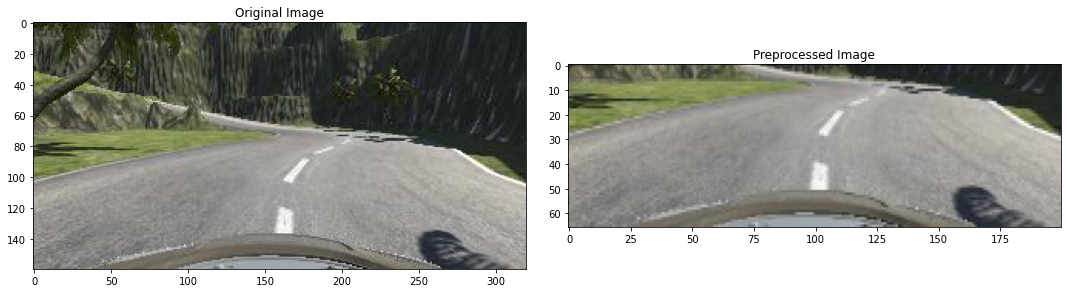

In [13]:
# Illustration of side-by-side Original Image Vs Preprocessed Image:

# Reading image for preprocessing:
random_index = random.randint(0, len(X_train)-1)
image = image_paths[random_index]
original_image = mpimg.imread(image)
image=mpimg.imread(image)
preprocessed_image = image_preprocess(image)

# Visualizing the results:
fig, axes = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
plt.show()

### Data Augmentation:

In [14]:
# Creating series of functions that will help us with data augmentation utilizing the imgaug library:

# Defining zoom function:
def zoom(image):
    zoom = iaa.Affine(scale = (1, 1.3))
    image = zoom.augment_image(image)
    return image

# Defining pan function:
def pan(image):
    pan = iaa.Affine(translate_percent = {'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

# Defining brightness function:
def brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

# Defining yuv function:
def yuv(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    return image

# Defining gauss function:
def gauss(image):
    image = cv2.GaussianBlur(image,  (3, 3), 0)
    return image

In [15]:
def random_augment(image):
    
    """ Creating function to randomize the selection of data augmentation
         Parameters
         ----------
         image : array
             image is an array which contains pixels of the original dataset image
                 
         Returns
         -------
         image : array
             image is augmented version of the original image         
    """ 
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = brightness(image)
    if np.random.rand() < 0.5:
        image = yuv(image)
    if np.random.rand() < 0.5:
        image = gauss(image)
    return image

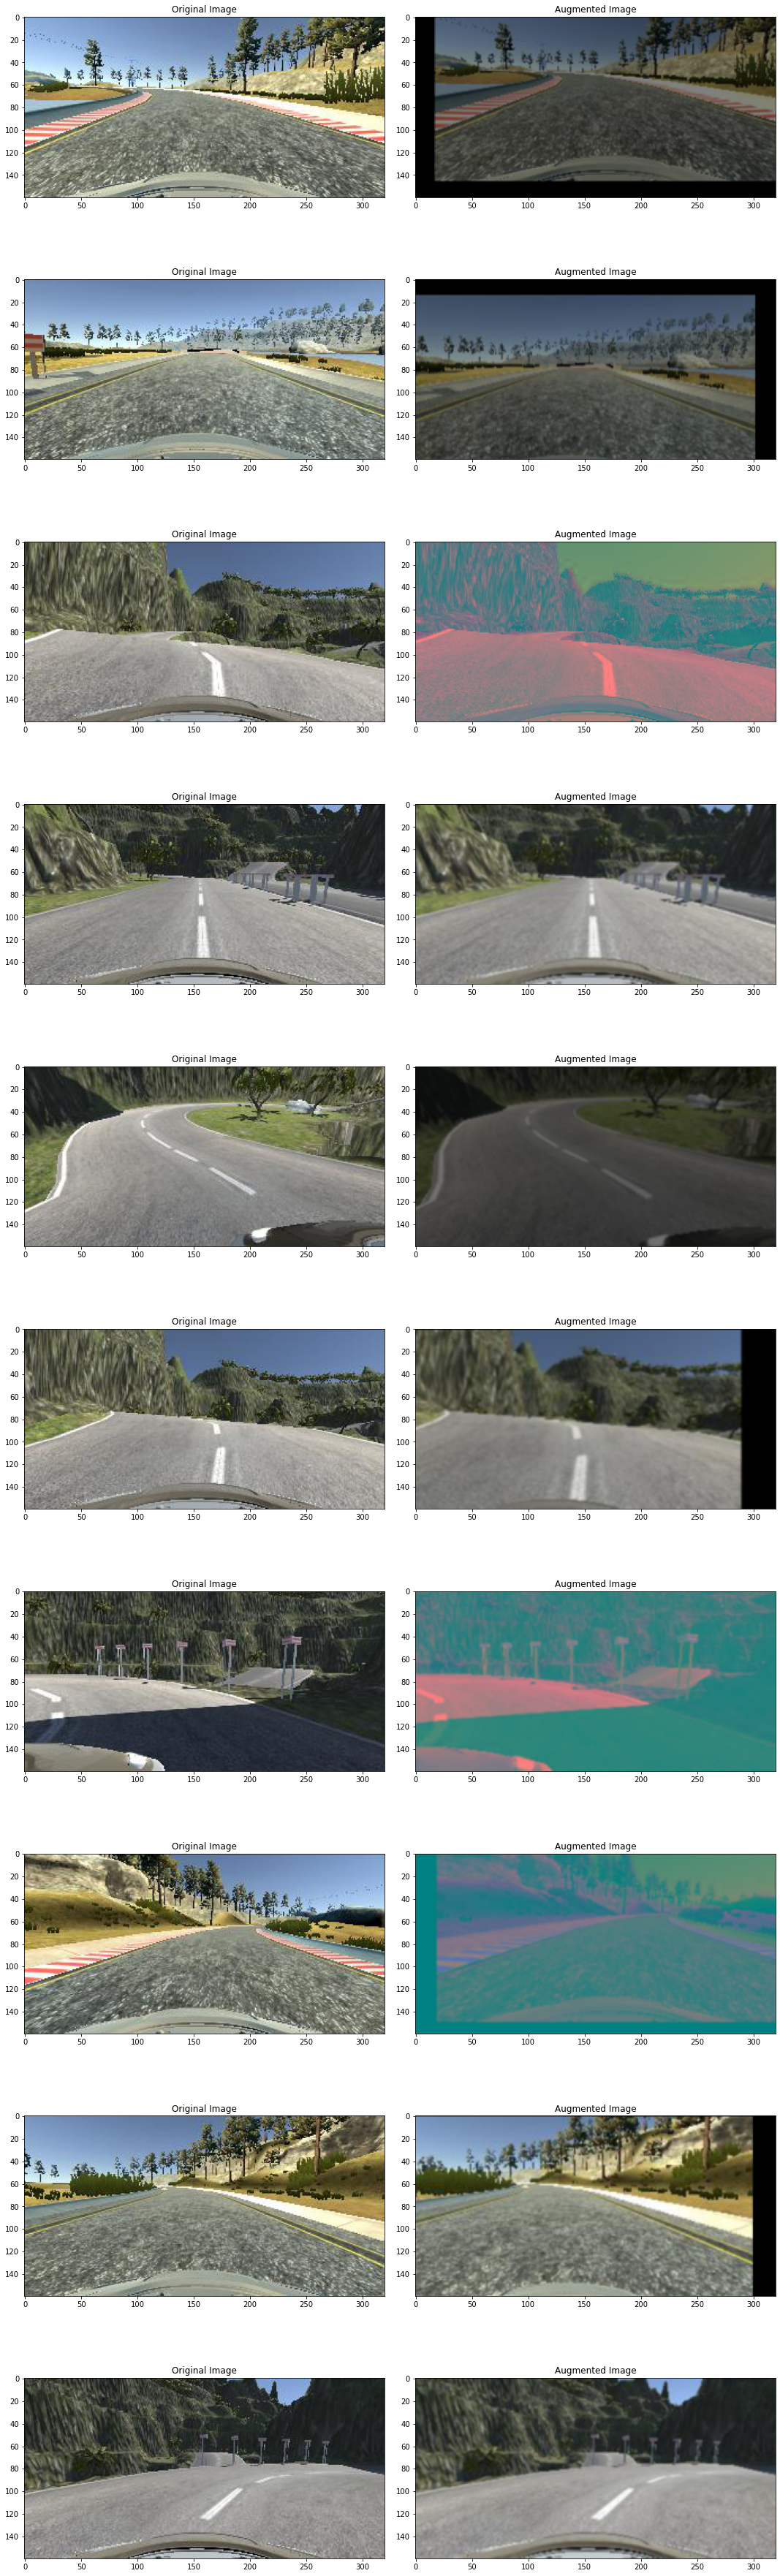

In [16]:
# Illustration of side-by-side Original Image Vs Augmented image:

# Visualzing the results:
fig, axes = plt.subplots(10, 2, figsize = (15, 50))
fig.tight_layout()

# Loading the image in two separate paths for clear illustration with 'For Loop':
for i in range(10):
    randnum = random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image = random_augment(random_image)
    axes[i][0].imshow(original_image)
    axes[i][0].set_title("Original Image")
    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title("Augmented Image")

### Generator:

In [16]:
def batch_generator(image_paths, steering_angle, batch_size, istraining):
    
    """ Creating 'batch_generator' function for memory efficiency
     Parameters
     ----------
     image_paths : array
         image_paths is one dimensional array with entries for center, left and right images
     steering_angle : float
         steering_angle is one dimensional array with measurments of steering angles
     batch_size : int
         batch_size is number of instances yield during one epoch
     istraining : bool
         istraining is used as flag which represents '1' for X_train dataset and '0' for X_test dataset           

     Returns
     -------
     batch_image : array
         batch_image is an array of preprocessed and randomly augmented images
     batch_steering : array
         batch_steering is one dimensional array with measurments of steering angles             
    """  
    while True:
        batch_image = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths)-1)

            if istraining:
                image = random_augment(image_paths[random_index])
                steering = steering_angle[random_index]
            else:
                image = mpimg.imread(image_paths[random_index])
                steering = steering_angle[random_index]

            image = image_preprocess(image)
            batch_image.append(image)
            batch_steering.append(steering)
        yield (np.asarray(batch_image), np.asarray(batch_steering))

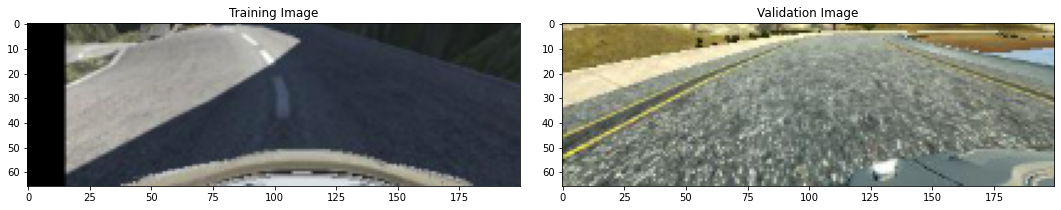

In [18]:
# Testing the 'batch_generator' and visualizing the results:

# Utilizing the batch_generator:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_test_gen, y_test_gen = next(batch_generator(X_test, y_test, 1, 0))

# Visualizing the results:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image')
axes[1].imshow(x_test_gen[0])
axes[1].set_title('Validation Image')
plt.show()

## Part 2: Behavioural Cloning:

### Task 1: Define Nvidia model and perform training procedures:

### Create Nvidia Model

In [17]:
# Creating the Sequential model object:
model = Sequential()

# Setting the convolutional layer segment, build from four layers:
model.add(Convolution2D(24, (5, 5), strides = (2, 2), input_shape = (66, 200, 3), activation = 'relu'))
model.add(Convolution2D(36, (5, 5), strides = (2, 2), activation = 'relu'))
model.add(Convolution2D(48, (5, 5), strides = (2, 2), activation = 'relu'))
model.add(Convolution2D(64, (3, 3), activation = 'relu'))

# Adding dropout layer:
model.add(Dropout(0.5))

# Inserting flatten layer:
model.add(Flatten())

# Setting the dense layer segment, build from four layers:
model.add(Dense(100, activation = 'relu'))

# Adding dropout layer:
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))

# Adding dropout layer:
#model.add(Dropout(0.5))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1)) 

# Model summary:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3840)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3

### Compile the Model:

In [20]:
# Designation of optimizer:
opt_adam = Adam(learning_rate = 1e-4)

# Compile procedure:
model.compile(loss = 'mean_squared_error', optimizer = opt_adam, metrics = ['mse'])

### Create Model Callbacks:

In [21]:
# Setting the Nvidia model:

# Path of model save:
path = 'Nvidia.h5'

# ModelCheckpoint monitoring:
callback_1 = ModelCheckpoint(path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

# Earlystopping monitoring:
callback_2 = EarlyStopping(patience = 10)

# Connecting both in list:
callback_list = [callback_1, callback_2]

### Train the Model:

In [22]:
# Fitting the Nvidia model:
history = model.fit(batch_generator(X_train, y_train, 100, 1),
                                    steps_per_epoch = 300, 
                                    epochs = 70,
                                    validation_data = batch_generator(X_test, y_test, 100, 0),
                                    validation_steps = 200,
                                    callbacks = callback_list,
                                    verbose = 1,
                                    shuffle = 1)

# Information print:
print('Training Finished')

Epoch 1/70
300/300 [==============================] - ETA: 0s - loss: 0.1026 - mse: 0.1026
Epoch 00001: val_loss improved from inf to 0.05726, saving model to Nvidia.h5
300/300 [==============================] - 198s 661ms/step - loss: 0.1026 - mse: 0.1026 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 2/70
300/300 [==============================] - ETA: 0s - loss: 0.0673 - mse: 0.0673
Epoch 00002: val_loss improved from 0.05726 to 0.04232, saving model to Nvidia.h5
300/300 [==============================] - 188s 627ms/step - loss: 0.0673 - mse: 0.0673 - val_loss: 0.0423 - val_mse: 0.0423
Epoch 3/70
300/300 [==============================] - ETA: 0s - loss: 0.0543 - mse: 0.0543
Epoch 00003: val_loss improved from 0.04232 to 0.03812, saving model to Nvidia.h5
300/300 [==============================] - 185s 618ms/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 4/70
300/300 [==============================] - ETA: 0s - loss: 0.0490 - mse: 0.0490
Epoch 00004: val_lo

In [18]:
# Loading the best model 'Nvidia.h5':

model_nvidia = load_model('Nvidia.h5')

### Save the model:

In [24]:
# Saving 'Nvidia.h5' model on local PC:

model_nvidia.save('Nvidia.h5')

### Task 2: Define comparison model - AlexNet (modified) and perform training procedures:

### Create AlexNet Model:
 
 - Note: Building a simplified version of the original AlexNet model, introducing modifications in order to fit the problem scenario and achieving more comparible model.

In [19]:
# Creating the Sequential model object:
model_alex = Sequential()

# Setting the first pair of convolutional layer and maxpooling layer:
model_alex.add(Convolution2D(32, (3, 3), strides = (2, 2), input_shape = (66, 200, 3), activation = 'elu'))
model_alex.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout layer:
model_alex.add(Dropout(0.25))

# Setting the second pair of convolutional layer and maxpooling layer:
model_alex.add(Convolution2D(64, (3, 3), strides = (2, 2), activation = 'elu'))
model_alex.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout layer:
model_alex.add(Dropout(0.25))

# Setting the third convolutional layer:
model_alex.add(Convolution2D(128, (3, 3), strides = (2, 2), activation = 'elu'))

# Adding dropout layer:
model_alex.add(Dropout(0.5))

# Inserting flatten layer:
model_alex.add(Flatten())

# Setting the dense layer segment, build from two layer:
model_alex.add(Dense(1024, activation = 'elu'))

# Adding dropout layer:
model_alex.add(Dropout(0.5))
model_alex.add(Dense(1))

# Model summary:
model_alex.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 99, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 49, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 49, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 24, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 12, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 12, 64)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 5, 128)        

### Compile the Model:

In [26]:
# Designation of optimizer:
opt_adam = Adam(learning_rate = 1e-4)

# Compile procedure:
model_alex.compile(loss = 'mean_squared_error', optimizer = opt_adam, metrics = ['mse'])

### Create Model Callbacks:

In [27]:
# Setting the Nvidia model:

# Path of model save:
path = 'Simplified_Alex.h5'

# ModelCheckpoint monitoring:
callback_1 = ModelCheckpoint(path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

# Earlystopping monitoring:
callback_2 = EarlyStopping(patience = 10)

# Connecting both in list:
callback_list = [callback_1, callback_2]

### Train the Model:

In [28]:
# Fitting the AlexNet model:
history_alex = model_alex.fit(batch_generator(X_train, y_train, 100, 1),
                                              steps_per_epoch = 300, 
                                              epochs = 60,
                                              validation_data = batch_generator(X_test, y_test, 100, 0),
                                              validation_steps = 200,
                                              callbacks = callback_list,
                                              verbose = 1,
                                              shuffle = 1)

# Information print:
print('Training Finished')

Epoch 1/60
300/300 [==============================] - ETA: 0s - loss: 0.1393 - mse: 0.1393
Epoch 00001: val_loss improved from inf to 0.08468, saving model to Simplified_Alex.h5
300/300 [==============================] - 153s 510ms/step - loss: 0.1393 - mse: 0.1393 - val_loss: 0.0847 - val_mse: 0.0847
Epoch 2/60
300/300 [==============================] - ETA: 0s - loss: 0.1023 - mse: 0.1023
Epoch 00002: val_loss improved from 0.08468 to 0.06185, saving model to Simplified_Alex.h5
300/300 [==============================] - 154s 514ms/step - loss: 0.1023 - mse: 0.1023 - val_loss: 0.0619 - val_mse: 0.0619
Epoch 3/60
300/300 [==============================] - ETA: 0s - loss: 0.0887 - mse: 0.0887
Epoch 00003: val_loss improved from 0.06185 to 0.05984, saving model to Simplified_Alex.h5
300/300 [==============================] - 152s 508ms/step - loss: 0.0887 - mse: 0.0887 - val_loss: 0.0598 - val_mse: 0.0598
Epoch 4/60
300/300 [==============================] - ETA: 0s - loss: 0.0848 - mse:

In [20]:
# Loading the best model 'Simplified_Alex.h5':

model_alex_ = load_model('Simplified_Alex.h5')

### Save the model:

In [30]:
# Saving 'Simplified_Alex.h5' model on local PC:

model_alex_.save('Simplified_Alex.h5')

### Task 3: Define transfer learning model - MobileNet and perform training procedures:

### Employe MobileNet Model:

In [22]:
# Create MobileNet pretrained model object:

mobile = MobileNet(weights = 'imagenet', include_top = False, input_shape = (66, 200, 3))

In [23]:
# Print the summary of MobileNet:

mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 66, 200, 3)]      0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 67, 201, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 33, 100, 32)       864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 33, 100, 32)       128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 33, 100, 32)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 33, 100, 32)       288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 33, 100, 32)

In [33]:
# Freeze total of 28 convolution blocks, counting depthwise and pointwise convolutions as seperate layers: 

# Freezing the layers:
for layer in mobile.layers:
    layer.trainable = True

# Make sure you have frozen the correct layers:
for i, layer in enumerate(mobile.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1 True
3 conv1_bn True
4 conv1_relu True
5 conv_dw_1 True
6 conv_dw_1_bn True
7 conv_dw_1_relu True
8 conv_pw_1 True
9 conv_pw_1_bn True
10 conv_pw_1_relu True
11 conv_pad_2 True
12 conv_dw_2 True
13 conv_dw_2_bn True
14 conv_dw_2_relu True
15 conv_pw_2 True
16 conv_pw_2_bn True
17 conv_pw_2_relu True
18 conv_dw_3 True
19 conv_dw_3_bn True
20 conv_dw_3_relu True
21 conv_pw_3 True
22 conv_pw_3_bn True
23 conv_pw_3_relu True
24 conv_pad_4 True
25 conv_dw_4 True
26 conv_dw_4_bn True
27 conv_dw_4_relu True
28 conv_pw_4 True
29 conv_pw_4_bn True
30 conv_pw_4_relu True
31 conv_dw_5 True
32 conv_dw_5_bn True
33 conv_dw_5_relu True
34 conv_pw_5 True
35 conv_pw_5_bn True
36 conv_pw_5_relu True
37 conv_pad_6 True
38 conv_dw_6 True
39 conv_dw_6_bn True
40 conv_dw_6_relu True
41 conv_pw_6 True
42 conv_pw_6_bn True
43 conv_pw_6_relu True
44 conv_dw_7 True
45 conv_dw_7_bn True
46 conv_dw_7_relu True
47 conv_pw_7 True
48 conv_pw_7_bn True
49 conv_pw_7_relu True
5

In [34]:
# Create CNN model object with inserted MobileNet trained network:

# Creating the Sequential model:
model_mobile = Sequential()

# Inserting the MobileNet trained network:
model_mobile.add(mobile)

# Inserting flatten layer:
model_mobile.add(Flatten())

# Inserting dense layer:
model_mobile.add(Dense(1))

# Model summary:
model_mobile.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 6, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 12289     
Total params: 3,241,153
Trainable params: 3,219,265
Non-trainable params: 21,888
_________________________________________________________________


### Compile the Model:

In [35]:
# Designation of optimizer:
opt_adam = Adam(learning_rate = 1e-4)

# Compile procedure:
model_mobile.compile(loss = 'mean_squared_error', optimizer = opt_adam, metrics = ['mse'])

### Create Model Callbacks:

In [36]:
# Setting model_mobile:

# Path of model save:
path = 'ModelMobile.h5'

# ModelCheckpoint monitoring:
callback_1 = ModelCheckpoint(path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

# Earlystopping monitoring:
callback_2 = EarlyStopping(patience = 5)

# Connecting both in list:
callback_list = [callback_1, callback_2]

### Train the Model:

In [37]:
# Fitting the model_mobile:
history_mobile = model_mobile.fit(batch_generator(X_train, y_train, 100, 1),
                                                  steps_per_epoch = 300, 
                                                  epochs = 15,
                                                  validation_data = batch_generator(X_test, y_test, 100, 0),
                                                  validation_steps = 200,
                                                  callbacks = callback_list,
                                                  verbose = 1,
                                                  shuffle = 1)

# Information print:
print('Training Finished')

Epoch 1/15
300/300 [==============================] - ETA: 0s - loss: 2.1420 - mse: 2.1420
Epoch 00001: val_loss improved from inf to 1.76170, saving model to ModelMobile.h5
300/300 [==============================] - 1037s 3s/step - loss: 2.1420 - mse: 2.1420 - val_loss: 1.7617 - val_mse: 1.7617
Epoch 2/15
300/300 [==============================] - ETA: 0s - loss: 0.7532 - mse: 0.7532
Epoch 00002: val_loss improved from 1.76170 to 0.67217, saving model to ModelMobile.h5
300/300 [==============================] - 1039s 3s/step - loss: 0.7532 - mse: 0.7532 - val_loss: 0.6722 - val_mse: 0.6722
Epoch 3/15
300/300 [==============================] - ETA: 0s - loss: 0.2618 - mse: 0.2618
Epoch 00003: val_loss improved from 0.67217 to 0.24355, saving model to ModelMobile.h5
300/300 [==============================] - 1046s 3s/step - loss: 0.2618 - mse: 0.2618 - val_loss: 0.2436 - val_mse: 0.2436
Epoch 4/15
300/300 [==============================] - ETA: 0s - loss: 0.1261 - mse: 0.1261
Epoch 0000

In [24]:
# Loading the model 'Model_Mobile.h5':

model_mobile_ = load_model('ModelMobile.h5')

### Save the model:

In [39]:
# Saving 'Model_Mobile.h5' model on local PC:

model_mobile_.save('ModelMobile.h5')

## Part 3: Analysis and Visualizing the Results:

### Display Results:

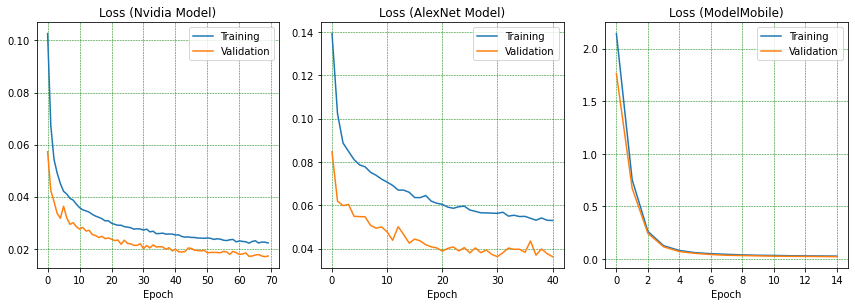

In [40]:
# Visualizing the resutls from training and validation:

fig, axes = plt.subplots(1, 3, figsize = (12, 4))
fig.tight_layout()

axes[0].plot(history.history['loss'], label = 'Loss')
axes[0].plot(history.history['val_loss'], label = 'Val_Loss')
axes[0].legend(['Training', 'Validation'])
axes[0].grid(color = 'green', linestyle = '--', linewidth = 0.5)
axes[0].set_title('Loss (Nvidia Model)')
axes[0].set_xlabel('Epoch')
axes[1].plot(history_alex.history['loss'], label = 'Loss')
axes[1].plot(history_alex.history['val_loss'], label = 'Val_Loss')
axes[1].legend(['Training', 'Validation'])
axes[1].grid(color = 'green', linestyle = '--', linewidth = 0.5)
axes[1].set_title('Loss (AlexNet Model)')
axes[1].set_xlabel('Epoch')
axes[2].plot(history_mobile.history['loss'], label = 'Loss')
axes[2].plot(history_mobile.history['val_loss'], label = 'Val_Loss')
axes[2].legend(['Training', 'Validation'])
axes[2].grid(color = 'green', linestyle = '--', linewidth = 0.5)
axes[2].set_title('Loss (ModelMobile)')
axes[2].set_xlabel('Epoch')
plt.show()

### Make Predictions:

In [27]:
# Processing the X_test dataset with 'image_preprocess_' function in order to make predictions:

def image_preprocess_(image):
     
    """ Creating function with preprocessing techniques for image processing and image reading
         Parameters
         ----------
         image : array
             image is an array which contains pixels of the original dataset image
                 
         Returns
         -------
         image : array
             image is modified version of the original image         
    """
    image = mpimg.imread(image)
    image = image[60:, :, :]
    image = cv2.resize(image, (200, 66))
    image = image/255
    return image

In [28]:
# Converting the X_test dataset for predictions:

X_test = np.array(list(map(image_preprocess_, X_test)))

#### Nvidia Model Predictions:

In [29]:
# Making predictions with the Nvidia model:

nvidia_predictions = model_nvidia.predict(X_test)

#### AlexNet Model Predictions:

In [30]:
# Making predictions with the AlexNet model:

alex_predictions = model_alex_.predict(X_test)

#### ModelMobile Predictions:

In [31]:
# Making predictions with the ModelMobile:

mobile_predictions = model_mobile_.predict(X_test)

### Visualize the Predictions:

 - Note: Steering angle predictions used for autonomous driving, represented as steering angle values:
   - Ground Truth plotted with magenta color.
   - Nvidia model plotted with green color.
   - AlexNet model plotted with orange color.
   - ModelMobile plotted with blue color.

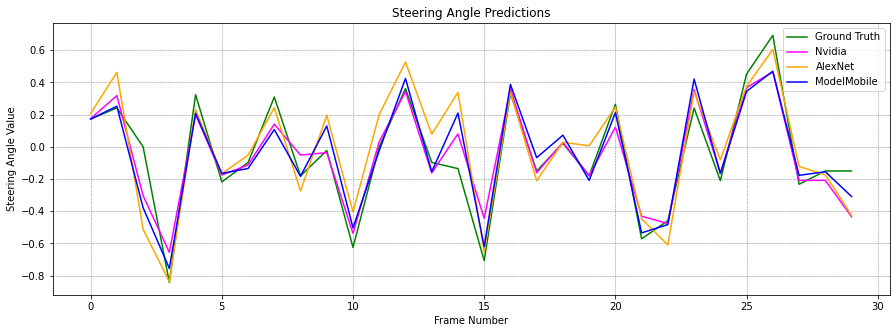

In [46]:
# Visualizing the first thrty predictions:

figure = plt.figure(figsize = (15, 5))
plt.plot(y_test[0:30], color = 'green')
plt.plot(nvidia_predictions[0:30], color = 'magenta')
plt.plot(alex_predictions[0:30], color = 'orange')
plt.plot(mobile_predictions[0:30], color = 'blue')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
plt.title('Steering Angle Predictions')
plt.xlabel('Frame Number')
plt.ylabel('Steering Angle Value')
plt.legend(['Ground Truth','Nvidia', 'AlexNet', 'ModelMobile'])
plt.show()

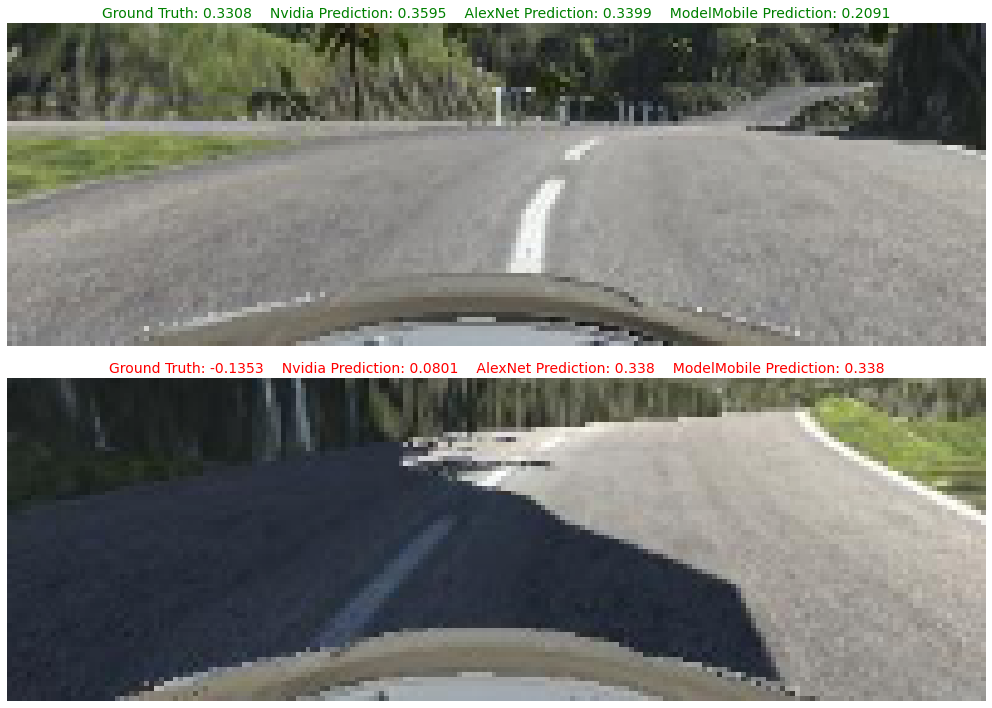

In [47]:
# Verifing the precision of the models predictions by comparison with the original steering labels:

# Illustrating correct prediction:
img_correct = X_test[16]
st_gt = round(y_test[16], 4)
st_nv = round(nvidia_predictions[16][0], 4)
st_al = round(alex_predictions[16][0], 4)
st_mb = round(mobile_predictions[16][0], 4)

# Illustrating incorrect prediction:
img_incorrect = X_test[14]
st_gt_ = round(y_test[14], 4)
st_nv_ = round(nvidia_predictions[14][0], 4)
st_al_ = round(alex_predictions[14][0], 4)
st_mb = round(mobile_predictions[14][0], 4)

# Visualizing the test image:
fig, axes = plt.subplots(2, 1, figsize = (18, 10))
fig.tight_layout()


axes[0].imshow(img_correct)
axes[0].set_title('Ground Truth: ' + str(st_gt) + '    ' + \
          'Nvidia Prediction: ' + str(st_nv) + '    ' + \
          'AlexNet Prediction: ' + str(st_al) + '    ' + \
          'ModelMobile Prediction: ' + str(st_mb),\
           color = 'green', fontsize = 14)
axes[0].axis('off')
axes[1].imshow(img_incorrect)
axes[1].set_title('Ground Truth: ' + str(st_gt_) + '    ' + \
          'Nvidia Prediction: ' + str(st_nv_) + '    ' + \
          'AlexNet Prediction: ' + str(st_al_) + '    ' + \
          'ModelMobile Prediction: ' + str(st_al_),\
           color = 'red', fontsize = 14)
axes[1].axis('off')
plt.show()

### Metric Calculation:

#### Notes:

- Errors summarizes on average how close predictions were to their expected values.

- There are three error metrics that are commonly used for evaluating and reporting the performance of a regression model, they are:

  - Mean Squared Error (MSE).
  - Root Mean Squared Error (RMSE).
  - Mean Absolute Error (MAE)

#### Nvidia Model Metrics:

In [32]:
# Calculating the mean squared error, root mean squared error and mean absolute error:

# Inserting the real values in variable:
expected = y_test

# Inserting the predicted values in variable:
nvidia_pred = nvidia_predictions

# Calculating errors:

# Mean Squared Error (MSE):
mse_n = mean_squared_error(expected, nvidia_pred)

# Root Mean Squared Error (RMSE):
rmse_n = mean_squared_error(expected, nvidia_pred, squared = False)

# Mean Absolute Error (MAE):
mae_n = mean_absolute_error(expected, nvidia_pred)

#### AlexNet Model Metrics:

In [33]:
# Calculating the mean squared error, root mean squared error and mean absolute error:

# Inserting the real values in variable:
expected = y_test

# Inserting the predicted values in variable:
alex_pred = alex_predictions

# Calculating errors:

# Mean Squared Error (MSE):
mse_a = mean_squared_error(expected, alex_pred)

# Root Mean Squared Error (RMSE):
rmse_a = mean_squared_error(expected, alex_pred, squared = False)

# Mean Absolute Error (MAE):
mae_a = mean_absolute_error(expected, alex_pred)

#### ModelMobile Metrics:

In [34]:
# Calculating the mean squared error, root mean squared error and mean absolute error:

# Inserting the real values in variable:
expected = y_test

# Inserting the predicted values in variable:
mobile_pred = mobile_predictions

# Calculating errors:

# Mean Squared Error (MSE):
mse_m = mean_squared_error(expected, mobile_pred)

# Root Mean Squared Error (RMSE):
rmse_m = mean_squared_error(expected, mobile_pred, squared = False)

# Mean Absolute Error (MAE):
mae_m = mean_absolute_error(expected, mobile_pred)

In [35]:
# Printing the Metrics results:

data = {'Metrics':  ['MSE', 'RMSE', 'MAE'],
        'Nvidia': ['%.4f' % mse_n, '%.4f' % rmse_n, '%.4f' % mae_n],
        'AlexNet': ['%.4f' % mse_a, '%.4f' % rmse_a, '%.4f' % mae_a],
        'ModelMobile': ['%.4f' % mse_m, '%.4f' % rmse_m, '%.4f' % mae_m]
        }

# Converting the data into DataFrame for clear reading:
metrics = pd.DataFrame(data)

# Printing the results:
metrics

Metrics  Nvidia AlexNet ModelMobile
0     MSE  0.0170  0.0361      0.0222
1    RMSE  0.1304  0.1901      0.1490
2     MAE  0.0952  0.1461      0.1116

### Approximated Accuracy:

#### Notes:

- Approximate Accuracy evaluated by predefined treshold of 0.26 radians ~ (15 degrees).

- Approximate Accuracy evaluated on basis of mislabeled prediction.

In [36]:
def approx_acc_tr(expected, predicted):
    
    """ Creating function for calculating approximate accuracy evaluated by predefined treshold
         Parameters
         ----------
         expected : array
             expected is one dimensional array with measurments of steering angles
         predicted : array
             predicted is one dimensional array with predicted measurments of steering angles
                 
         Returns
         -------
         accuracy : float
             accuracy is mean value of calculated errors         
    """    
    difference = []
    for i in range(0, len(expected)-1):
        error = abs(expected[i] - predicted[i])
        if error < 0.26:
            difference.append(1)
        else:
            difference.append(0)                  
    accuracy = np.mean(difference) * 100    
    return accuracy 

In [37]:
# Appling 'approx_acc_tr' function to make approximated accuracy based on treshold:

ap_tr_nv = round((approx_acc_tr(y_test, nvidia_predictions)), 2)
ap_tr_an = round((approx_acc_tr(y_test, alex_predictions)), 2)
ap_tr_mm = round((approx_acc_tr(y_test, mobile_predictions)), 2)

In [38]:
# Printing the Approximated Accuracy:

error = {'Metrics':  ['Accuracy'],
         'Nvidia': [ap_tr_nv],
         'AlexNet': [ap_tr_an],
         'ModelMobile': [ap_tr_mm]
        }

# Converting the data into DataFrame for clear reading:
table_acc = pd.DataFrame(error)

# Printing the results:
table_acc

Metrics  Nvidia  AlexNet  ModelMobile
0  Accuracy   94.11    83.91         91.5

In [39]:
def approx_acc_mp(expected, predicted):
    
    """ Creating function for calculating approximate accuracy evaluated on basis of mislabeled prediction 
         Parameters
         ----------
         expected : array
             expected is one dimensional array with measurments of steering angles
         predicted : array
             predicted is one dimensional array with predicted measurments of steering angles
                 
         Returns
         -------
         accuracy : float
             accuracy is mean value of calculated errors         
    """    
    difference = []
    for i in range(0, len(expected)-1):
        if expected[i] > 0 and predicted[i] > 0:
            difference.append(1)
        elif expected[i] < 0 and predicted[i] < 0:
            difference.append(1)
        elif expected[i] == 0 and predicted[i] == 0:
            difference.append(1)
        else:
            difference.append(0)            
    accuracy = np.mean(difference) * 100    
    return accuracy 

In [40]:
# Appling 'approx_acc_mp' function to make approximated accuracy based on mislabeled predictions:

ap_mp_nv = round((approx_acc_mp(y_test, nvidia_predictions)), 2)
ap_mp_an = round((approx_acc_mp(y_test, alex_predictions)), 2)
ap_mp_mm = round((approx_acc_mp(y_test, mobile_predictions)), 2)

In [41]:
# Printing the Approximated Accuracy:

error_mp = {'Metrics':  ['Accuracy'],
            'Nvidia': [ap_mp_nv],
            'AlexNet': [ap_mp_an],
            'ModelMobile': [ap_mp_mm]         
           }

# Converting the data into DataFrame for clear reading:
table_acc_mp = pd.DataFrame(error_mp)

# Printing the results:
table_acc_mp

Metrics  Nvidia  AlexNet  ModelMobile
0  Accuracy   86.78    80.97        84.93

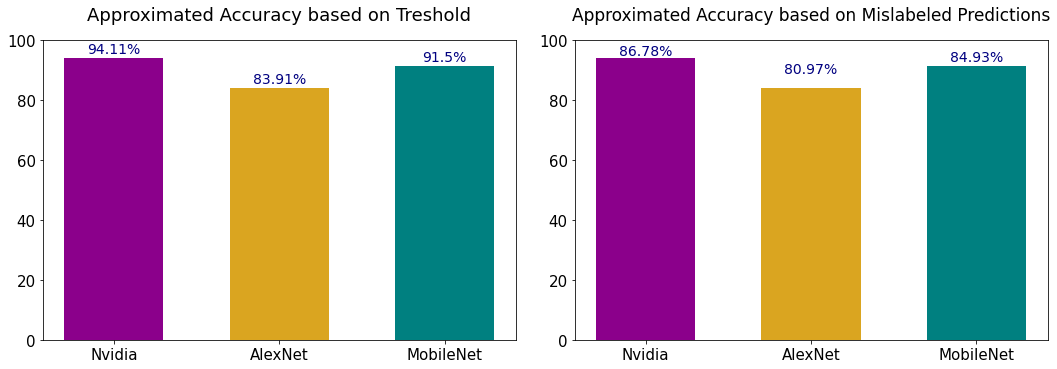

In [47]:
# Visualizing the results for both types of approximated accuracy and model comparison analysis:

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
fig.tight_layout()

model_name = ['Nvidia', 'AlexNet', 'MobileNet']
results_1 = [ap_tr_nv, ap_tr_an, ap_tr_mm]
results_2 = [ap_mp_nv, ap_mp_an, ap_mp_mm]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15        
       }
plt.rc('font', **font)

axes[0].bar(model_name, results_1, color = ['darkmagenta', 'goldenrod', 'teal'], width = 0.6)
axes[0].set_title('Approximated Accuracy based on Treshold', pad = 20)
for index, value in enumerate(results_1):
    axes[0].text(index, value + 3, str(value) + '%', 
                 color = 'navy',                 
                 ha = 'center', va = 'center', 
                 fontsize = 14)
axes[0].set_ylim(0, 100)    
axes[1].bar(model_name, results_1, color = ['darkmagenta', 'goldenrod', 'teal'], width = 0.6)
axes[1].set_title('Approximated Accuracy based on Mislabeled Predictions', fontsize = 17,  pad = 20)
for index, value in enumerate(results_2):
    axes[1].text(index, value + 9.5, str(value) + '%', 
                 color = 'navy',  
                 ha = 'center', va = 'center', 
                 fontsize = 14)
axes[1].set_ylim(0, 100)
plt.show()